In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
!pip install wrds
import wrds
import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100

def get_daily_wrds_multiple_ticker(tickers,conn):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) & (permnos['nameenddt']==permnos['nameenddt'].max())]
    # Extract unique PERMNOs
    permno_list = permnos['permno'].unique().tolist()
    print(permno_list)

    # Query daily stock file for the specified PERMNOs
    query = f"""
        SELECT permno, date, ret, retx, prc       
        FROM crsp.dsf
        WHERE permno IN ({','.join(map(str, permno_list))})
        ORDER BY date
    """
    daily_returns = conn.raw_sql(query, date_cols=['date'])
    daily_returns = daily_returns.merge(permnos[['permno', 'ticker']], on='permno', how='left')
    # Pivot data to have dates as index and tickers as columns
    daily_returns = daily_returns.pivot(index='date', columns='ticker', values='ret')    
    daily_returns=daily_returns[tickers]



    return daily_returns


    
def get_permnos(tickers,conn):
  
    # Retrieve PERMNOs for the specified tickers
    permnos = conn.get_table(library='crsp', table='stocknames', columns=['permno', 'ticker', 'namedt', 'nameenddt'])
    permnos['nameenddt']=pd.to_datetime(permnos['nameenddt'])
    permnos = permnos[(permnos['ticker'].isin(tickers)) ]
    



    return permnos

# Multi-factor models


---

**🎯 Learning Objectives**

By the end of this chapter, you should be able to:

1. **Understand Multi-Factor Models**: Grasp the rationale behind using multiple factors to explain asset returns and how they extend beyond single-factor models like CAPM.

2. **Estimate Multi-Factor Models**: Learn the time-series approach to estimating multi-factor models, including data requirements and regression techniques.

3. **Apply Multi-Factor Models**: Utilize these models to analyze asset returns, decompose variance, and improve the estimation of covariance matrices. 

4. **Assess Portfolio Risk**: Evaluate how adding assets affects portfolio risk and understand the implications for diversification. 

5. **Perform Performance Attribution**: Break down portfolio performance to attribute returns to various factors, aiding in investment decision-making.

6. **Transition from Asset to Portfolio Level**: Aggregate asset-level factor exposures to understand portfolio-level risks and returns 

7. **Explore Characteristic-Based models of return attribution**: Delve into characteristic-based models that explain returns based on firm-specific attributes. 

---




So far we have focused on the market as our single factor. 

In practice it is standard to use factor models with many factors

Additional factors

- soak up risk making measure of alpha easier
- Difference out other sources of expected excess returns that are easy to get access to
- Allows for better risk management


We deal with this, by simply adding more factors to our model. Say we now have $m$ different factors

$$r_t^i=b_{i,1}f_t^1+b_{i,2}f_t^2+b_{i,3}f_t^3+...+b_{i,m}f_t^m+\epsilon_{i,t}$$


Where $b_{i,j}$ measures the exposure of asset $i$ to factor $j$

IF we stack these exposures in a m by 1 vector $B_i=[b_{i,1},b_{i,2},...b_{i,M}]$ and the factors in a m by 1 vector $F_t=[f^1_t,f^2_t,...,f^m_t]$ we can write this in matrix notation

$$r_t^i=B_i@F_t+u_{i,t}$$


As before we can also stack the individual returns :

$$R_t=B@F_t+U_t$$

where

-  $R_t$ is a n by 1 vector with the excess returns of the n assets
-  $B$ is n by m matrix where each row has the exposure of an asset with respect to each M factor and each column has the exposures of the different assets with respect to a particular factor 
- $U_t$ as before is a n by 1 vector with the residual risk of each asset







**"Endogenous" Benchmarking**

* it is common for large portfolio allocators to set benchmarks for the managers that they allocate to

* The most common benchmark is simply returns of the S&P500 which is almost the same thing as the returns of the market portfolio ( large caps dominate the returns of any market-cap portfolio)

* You might also have endogenous benchmarks

* Use a set of Factors F and estimate $r^b_t=\sum \beta_j F_{j,t}$ 

* I.e use as a bechmark the multifactor combination that best replicates the portfolio.

* typically this is not done contractually but implicitly: You will allocate to the different funds based on their alpha

* Captures the idea that one should pay different prices for alpha (very hard to get) and beta( easier, the gains are in implementation)





## Estimating a multi-factor model: The Time-series approach

We start with the factors and estimate the betas using time-series data

This works particularly well when the factors are excess returns themselves

For each asset We run a tim-series regression with the excess returns of the asset as the the dependent variable and the excess returns on the factors as the independent variables

## Application

What do you get when you invest in a Momentum ETF?

1. Get daily return data on the larger ETFs claiming to implement the momentum factor
2. Get factors excess returns: Market, Size (SMB), Value (HML), Profitability (RMW), Investment (CMA) , and Momentum (MOM)
3. Run a time series regression for each ETF on the factors
4. Look at alphas and betas

In [2]:
tickers = ["MTUM", "SPMO", "XMMO", "IMTM", "XSMO", "PDP", "JMOM", "DWAS", "VFMO", "XSVM", "QMOM"]
conn=wrds.Connection()
# Get daily returns for the specified tickers
df_ETF=get_daily_wrds_multiple_ticker(tickers,conn)
# Get daily factors
df_factor=get_factors('FF6','daily')
# Align the dataframes
df_ETF, df_factor = df_ETF.align(df_factor, join='inner', axis=0)
# Subtract risk-free rate from ETF returns
df_ETF=df_ETF.subtract(df_factor['RF'],axis=0)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
[13512, 13851, 15161, 15725, 17085, 17392, 17622, 90621, 90622, 90623, 91876]


In [3]:


import statsmodels.api as sm

X = df_factor.drop(columns=['RF'])
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df_ETF[tickers[1]]
X=X[y.isna()==False]
y=y[y.isna()==False]
model = sm.OLS(y, X).fit(dropna=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   SPMO   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     2242.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:34:16   Log-Likelihood:                 8217.0
No. Observations:                2069   AIC:                        -1.642e+04
Df Residuals:                    2062   BIC:                        -1.638e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.572e-05      0.000      0.454      0.6

In [4]:
Results=pd.DataFrame([],index=tickers,columns=X.columns)
for ticker in tickers:
    y = df_ETF[ticker]
    X = df_factor.drop(columns=['RF'])
    X = sm.add_constant(X) 
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    Results.loc[ticker,:]=model.params
    Results.at[ticker,'t_alpha']=model.tvalues['const']
    Results.at[ticker,'ivol']=model.resid.std()*252**0.5
    #Results.at[ticker,X.columns[1:]]=model.params[X.columns[1:]]

Results.loc[:,'const']=Results.loc[:,'const']*252
Results.rename(columns={'const':'alpha'},inplace=True)
Results=Results[['alpha','t_alpha','Mkt-RF','SMB','HML','RMW','CMA','MOM','ivol']]
Results

,alpha,t_alpha,Mkt-RF,SMB,HML,RMW,CMA,MOM,ivol
MTUM,-0.005012,-0.300789,1.01803,-0.107,-0.062138,-0.117292,-0.011854,0.316422,0.054317
SPMO,0.011521,0.454353,0.999749,-0.167316,-0.038834,-0.024316,0.076116,0.245338,0.072404
XMMO,0.006211,0.322732,1.043315,0.320758,0.020201,0.030898,-0.090631,0.193039,0.083264
IMTM,-0.028412,-0.849759,0.798808,-0.019567,0.075919,-0.126253,0.078522,0.127906,0.099686
XSMO,-0.011826,-0.570276,0.987091,0.846153,0.173362,0.084136,-0.077522,0.161215,0.089721
PDP,-0.012504,-0.811631,1.054572,0.138325,-0.006651,-0.079877,-0.205302,0.252667,0.063018
JMOM,0.006281,0.276272,0.963352,0.007072,-0.07626,-0.07507,-0.052893,0.099189,0.056012
DWAS,-0.001649,-0.076007,1.093378,1.079318,0.233582,-0.230806,-0.087208,0.408747,0.073130
VFMO,0.018697,0.859105,1.030837,0.446082,0.183954,-0.222156,-0.053664,0.396948,0.052463
XSVM,-0.002226,-0.115417,0.935784,0.977751,0.502337,0.319454,0.254056,-0.064561,0.083454


How should we evaluate these funds?

Which fund is "better"? Is it all about alpha in this case?

What are other things that we should be looking at?

Is this table providing a fair comparison across funds?


## Variance decomposition

The betas measure the exposure of the asset return to the factor, but it does not give an accurate way of thinking which factor drives the most of the variation in the asset as factors can have very different variances

$$1=\frac{Cov(r^i_t,r^i_t)}{Var(r^i_t)}=\frac{Cov(r^i_t,\sum_j^m \beta_{i,j}f^j_t+\epsilon^i_t)}{Var(r^i_t)}$$

$$1=\frac{\sum_j^m \beta_{i,j}Cov(r^i_t,f^j_t)+\sigma^2_{\epsilon}}{Var(r^i_t)}$$


The the variance share of factor j is $\frac{\beta_{i,j}Cov(r^i_t,f^j_t)}{Var(r^i_t)}$ and the share of non-factor variance is $\frac{\sigma^2_{\epsilon}}{Var(r^i_t)}$



In [7]:
VarianceDecomposition=pd.DataFrame([],index=tickers,columns=X.columns[1:])
FactorLoadings=pd.DataFrame([],index=tickers,columns=X.columns[1:])
VarianceIdiosyncratic=pd.DataFrame([],index=tickers,columns=['epsilon'])
for ticker in tickers:
    y = df_ETF[ticker]
    Factors = df_factor.drop(columns=['RF'])
    X = sm.add_constant(Factors) 
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    # get the covariance matrix of the factors and the dependent variable
    CovMatrix=pd.concat([y,X.iloc[:,1:]],axis=1).cov()
    # get the column of the covariance matrix corresponding to the dependent variable and exclude itself to get the covariance of 
    # the dependent variable with each factor
    FactorLoadings.loc[ticker,:]=model.params[1:]
    VarianceIdiosyncratic.loc[ticker,'epsilon']=model.resid.var()
    VarianceDecomposition.loc[ticker,:]=model.params[1:]*CovMatrix.iloc[1:,0]/y.var()*100
    # Get the residual variance
    VarianceDecomposition.at[ticker,'epsilon']=model.resid.var()/y.var()*100



np.floor(VarianceDecomposition)

,Mkt-RF,SMB,HML,RMW,CMA,MOM,epsilon
MTUM,85,-1,0,1,0,4,8.0
SPMO,85,-1,0,0,-1,2,13.0
XMMO,83,4,0,-1,0,-2,13.0
IMTM,68,-1,-1,1,-1,-1,31.0
XSMO,70,16,1,-1,0,-3,14.0
PDP,90,1,-1,0,1,-2,7.0
JMOM,90,0,1,0,0,-1,6.0
DWAS,64,23,-1,2,0,1,8.0
VFMO,82,7,-2,2,0,2,4.0
XSVM,60,18,10,-2,0,1,10.0


What do we learn?

Decompositions like that extensively in the money management industry

- Used to classify managers in terms of styles--often called style analysis
- Used to control own portfolio factor risk to satisfy investment mandates 

When looking at a portfolio/fund you have two approaches to measure it's factor exposures
- Top down: what we did so far. run a time-series regression of the portfolio returns on the factor return
- Bottom up: from the asset factor exposures build the portfolio factor exposure


What are the benefits and drawbacks of each?


## Application: A better behaved co-variance matrix 

We have

$$R_t=B@F_t+u_t$$

Then

$$Var(R_t)=B@Var(F_t)@B.T+Var(U_t)$$

The big difference is that now $F$ is a vector of factors

so $Var(F_t)$ is a M by M variance covariance matrix, where M is the number of factors

array([1.1707586174771113e-05, 2.080317521040718e-05,
       2.751170238189328e-05, 3.94335833263887e-05,
       3.1943920861237906e-05, 1.5759114393840486e-05,
       1.2449711502349668e-05, 2.1222405771159763e-05,
       1.0922197920452e-05, 2.7637503923225132e-05, 6.784116852203246e-05],
      dtype=object)

In [18]:
Var_F=Factors.cov()
Cov=FactorLoadings @ Var_F @ FactorLoadings.T + np.diag(VarianceIdiosyncratic.values.reshape(-1))
Cov

,MTUM,SPMO,XMMO,IMTM,XSMO,PDP,JMOM,DWAS,VFMO,XSVM,QMOM
MTUM,0.00016,0.000143,0.000155,0.000117,0.000152,0.000158,0.000141,0.000175,0.000159,0.000139,0.000169
SPMO,0.000143,0.000159,0.00015,0.000114,0.000146,0.000152,0.000137,0.000166,0.000152,0.000138,0.00016
XMMO,0.000155,0.00015,0.0002,0.000127,0.000178,0.000171,0.000153,0.000203,0.000175,0.000173,0.000184
IMTM,0.000117,0.000114,0.000127,0.000136,0.000128,0.000127,0.000115,0.000144,0.000129,0.000127,0.000133
XSMO,0.000152,0.000146,0.000178,0.000128,0.000227,0.000173,0.000154,0.000223,0.000184,0.000198,0.000192
PDP,0.000158,0.000152,0.000171,0.000127,0.000173,0.000187,0.000154,0.000198,0.000174,0.000163,0.000184
JMOM,0.000141,0.000137,0.000153,0.000115,0.000154,0.000154,0.000152,0.000173,0.000154,0.000148,0.00016
DWAS,0.000175,0.000166,0.000203,0.000144,0.000223,0.000198,0.000173,0.000284,0.000215,0.000218,0.000229
VFMO,0.000159,0.000152,0.000175,0.000129,0.000184,0.000174,0.000154,0.000215,0.000195,0.000177,0.000196
XSVM,0.000139,0.000138,0.000173,0.000127,0.000198,0.000163,0.000148,0.000218,0.000177,0.000252,0.000175


Suppose you are trying to construct the minimum variance portfolio--say you think expected returns are undistinguishable across the funds, so you simply want to minimize variance

your optimal weight, if you knew the covariance matrix is

$$E[R^e]Var(R^e)^{-1}$$

- If we compare the in-sample Variance of our minimum variance portfolios for
    - The unrestricted case
    - The single-factor covariance
    - The multi-factor covariance

- which one will have lowest variance? What will have the highest?
- Now split the sample in two. Repeat the covariance estimation procedure for each of these approaches for the first half of the sample
- Now use the weights to compute the variance of each of the portfolios in the second half
- Is the order likely to change? Why? Why not?





## Application: How will your portfolio risk change as you add positions


You have portfolio $X_0$ and you want to sell w of your positions to invest in a fund with portfolio $X_1$. How your portfolio variance will change as a function of you reallocation?

- The answer is simple

$$Var(wX_1R_t+(1-w)X_0R_t)-Var(X_0R_t)$$

- But also kind of misleading since you might not have good data to estimate the variance of the new portfolio

- Now if you know each portfolio factor betas,$\beta_0=X_0@B$ and $\beta_1=X_1@B$ , and at least one of this portfolio is large and well diversified, then for small tilts, i.e. $w$ small, we have 


$$\frac{Var(wX_1R_t+(1-w)X_0R_t)-Var(X_0R_t)}{\Delta w}|_{w\approx 0} =\beta_1Var(F)\beta_0'$$


- The fact that one is well diversified just means that you can ignore the covariance-terms of the portfolios asset specific risks

- So you see above why a large pool of money when allocating money to an active manager will want to regulate their factor exposure

- funds with similar volatilities will be perceived as very different risks depending on how the exposure of portfolio relates to the exposure of the fund

For example, look at how your portfolio risk change if you go from an equal weighted portfolio of these ETFS to just investing in one of them, say MTUM

## Performance Attribution


- We can use factor models to decompose a manager strategy

- What explains their returns? 

- What tilts they have?  What kind of stocks they like?


### Application: What does Cathie Wood  Likes ? 



![Cathie Wood](../../assets/plots/CW_image.jfif)

Cathie Wood is a renowned stock-picker and the founder of ARK Invest, which manages around 60 billion in assets and invests in innovative technologies such as self-driving cars and genomics. She gained fame for her success in the male-dominated world of investing, her persuasive investment arguments, and her proven track record in the stock market. Prior to founding ARK Invest, she gained experience at The Capital Group, Jennison Associates, and AllianceBernstein, and co-founded Tupelo Capital Management, a hedge fund. Wood is known for her unconventional investment strategies and her advocacy for investing in disruptive technologies, which has garnered her a large following in the investing world. Her estimated net worth is around $250 million.


Citations:
https://www.nytimes.com/2021/08/22/business/cathie-wood-ark-stocks.html




In [ ]:
df=pd.read_pickle('https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/df_WarrenBAndCathieW.pkl')
_temp=df.dropna()
# select the columns to use as factors
Factors=_temp.drop(['BRK','RF','ARKK'],axis=1)
ArK=_temp.ARKK-_temp.RF

What are these factors?

* HML is the value strategy that buys high book to market firms and sell low book to market firms

* SMB is a size strategy that buys firms with low market capitalization and sell firms with high market capitalizations

* RmW is the strategy that buys firms with high gross profitability and sell firms with low gross profitability

* CmA is the strategy that buys firms that are investing little (low CAPEX) and sell firms that are investing a lot (high CAPEX) 

* MOM is the momentum strategy that buy stocks that did well in the last 12 months and short the ones that did poorly


We will discuss more later

for now just think of them as important trading strategies that practicioners know

In [ ]:

x= sm.add_constant(Factors)
y= ArK
results= sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     1069.
Date:                Thu, 28 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:24:08   Log-Likelihood:                 5908.9
No. Observations:                1804   AIC:                        -1.180e+04
Df Residuals:                    1797   BIC:                        -1.177e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.821      0.069   -3.03e-05       0.001
Mkt-RF         1.1736      0.020     58.714      0.000       1.134       1.213
SMB            0.6944      0.037     18.984      0.000       0.623       0.766
HML           -0.6521      0.038    -16.938      0.000      -0.728      -0.577
RMW           -0.9037      0.054    -16.883      0.000      -1.009      -0.799
CMA           -0.5034      0.071     -7.129      0.000      -0.642      -0.365
Mom           -0.0397      0.025     -1.559      0.119      -0.090       0.010
==============================================================================
Omnibus:                       55.310   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.873
Skew:                           0.116   Prob(JB):                     1.04e-28
Kurtosis:                       4.289   Cond. No.                         345.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- How much can we explain of ARKK return behavior?

- What kind of stocks CW likes?

- How much of her portfolio variance comes from market exposure alone?

- If you were to construct a replicating portfolio of her fund

- What would be the volatility of your residual risk?





## Bottom up: from assets factor risk to portfolio factor risk

Above we estimated fund factor exposures by looking at how the fund co-move with the different factors

An alternative is to look through the fund and compute asset factor loadings and from them compute the fund factor loadings

Consider portfolio with weights  $X$ that earns excess returns $r=X@R$ where R is the vector of asset excess returns.

Asset's excess returns satisfy a factor model

$$R=A+B@F+U$$

then the portfolio satisfies

$$r=X@R=X@(A+B@F+U)=X@A+X@B@F+X@U$$

In scalar notation this is simply

$$r=\sum_i x_i r_i=\sum_i x_i\alpha_i+ \sum_j \sum_i x_i \beta_{i,j}f_j+\sum_i x_i\epsilon_i$$

So the portfolio exposure to factor j is simply the dollar-weighted average of the asset betas

$$\beta_{p,j}=\sum_i x_i \beta_{i,j}$$

- For portfolios with high turnover, this approach will lead to better measurement of factor risk
- For portfolios that do not trade, then measuring individual asset betas might introduce unnecessary noise and extra work


In [33]:
import pandas as pd

date1='2014-12-31'
date2='2015-12-31'
date3='2016-12-31'
# Define the portfolio data
portfolio_data1 = {
    'date': [date1,date1,date1,date1,date1],
    'ticker': ['AAPL', 'GOOGL', 'MSFT','NVDA','AMZN'],
    'weight': [0.2,0.2, 0.2,0.2,0.2]
}

portfolio_data2 = {
    'date': [date2,date2,date2,date2],
    'ticker': ['COST', 'WMT', 'TGT','KR'],
    'weight': [0.25,0.25, 0.25,0.25]
}
# Concatenate the two dataframes
portfolio_df1 = pd.DataFrame(portfolio_data1)
portfolio_df2 = pd.DataFrame(portfolio_data2)

# Generate monthly dates from date1 to date2 and from date2 to now
date_range1 = pd.date_range(start=date1, end=date2, freq='B')
date_range2 = pd.date_range(start=date2, end=date3, freq='B')

# Create monthly dataframes for each portfolio
monthly_portfolio1 = pd.DataFrame(
    [(date, ticker, weight) for date in date_range1 for ticker, weight in zip(portfolio_df1['ticker'], portfolio_df1['weight'])],
    columns=['date', 'ticker', 'weight']
)
monthly_portfolio2 = pd.DataFrame(
    [(date, ticker, weight) for date in date_range2 for ticker, weight in zip(portfolio_df2['ticker'], portfolio_df2['weight'])],
    columns=['date', 'ticker', 'weight']
)

# Combine the monthly dataframes
final_portfolio_df = pd.concat([monthly_portfolio1, monthly_portfolio2], ignore_index=True)

# import ace_tools as tools
# tools.display_dataframe_to_user(name="Portfolio Monthly Weights", dataframe=final_portfolio_df)

final_portfolio_df 

,date,ticker,weight
0,2014-12-31,AAPL,0.20
1,2014-12-31,GOOGL,0.20
2,2014-12-31,MSFT,0.20
3,2014-12-31,NVDA,0.20
4,2014-12-31,AMZN,0.20
...,...,...,...
2353,2016-12-29,KR,0.25
2354,2016-12-30,COST,0.25
2355,2016-12-30,WMT,0.25
2356,2016-12-30,TGT,0.25


In [53]:
tickers = final_portfolio_df.ticker.unique().tolist()    
#conn=wrds.Connection()
# Get daily returns for the specified tickers
df_stocks=get_daily_wrds_multiple_ticker(tickers,conn)
# Get daily factors
df_factor=get_factors('FF6','daily')
df_factor=df_factor.dropna()
# Align the dataframes

# Subtract risk-free rate from ETF returns
df_stocks=df_stocks.subtract(df_factor['RF'],axis=0)
df_stocks

[10107, 14593, 16678, 49154, 55976, 84788, 86580, 87055, 90319]


ticker,AAPL,GOOGL,MSFT,NVDA,AMZN,COST,WMT,TGT,KR
1928-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-11-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df=df_stocks.stack()
df.name='eret'
df=final_portfolio_df.merge(df,left_on=['date','ticker'],right_index=True,how='left')
df

,date,ticker,weight,eret
0,2014-12-31,AAPL,0.20,-0.019019
1,2014-12-31,GOOGL,0.20,-0.008631
2,2014-12-31,MSFT,0.20,-0.012123
3,2014-12-31,NVDA,0.20,-0.015710
4,2014-12-31,AMZN,0.20,0.000161
...,...,...,...,...
2353,2016-12-29,KR,0.25,-0.002605
2354,2016-12-30,COST,0.25,-0.006340
2355,2016-12-30,WMT,0.25,-0.002031
2356,2016-12-30,TGT,0.25,-0.005380


**TOP DOWN**

For comparison lets estimate this fund factor exposure using the top down approach

Lets construct the portfolio return and then run the multi-factor regression

In [56]:
fund_return=df.groupby('date').apply(lambda x: (x['eret']*x['weight']).sum() )
df_factor, fund_return = df_factor.align(fund_return, join='inner', axis=0)

In [57]:
y=fund_return.copy()
X = df_factor.drop(columns=['RF'])
X = sm.add_constant(X) 
X=X[y.isna()==False]
y=y[y.isna()==False]
model = sm.OLS(y, X).fit(dropna=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     94.64
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           4.66e-79
Time:                        17:16:05   Log-Likelihood:                 1711.9
No. Observations:                 505   AIC:                            -3410.
Df Residuals:                     498   BIC:                            -3380.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.490      0.137      -0.000       0.001
Mkt-RF         0.9562      0.044     21.531      0.000       0.869       1.043
SMB           -0.1387      0.080     -1.732      0.084      -0.296       0.019
HML           -0.0802      0.097     -0.830      0.407      -0.270       0.109
RMW            0.6811      0.116      5.847      0.000       0.452       0.910
CMA           -0.4294      0.150     -2.855      0.004      -0.725      -0.134
MOM            0.1413      0.050      2.836      0.005       0.043       0.239
==============================================================================
Omnibus:                       99.867   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              369.570
Skew:                           0.859   Prob(JB):                     5.61e-81
Kurtosis:                       6.822   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now suppose you know the time of the portfolio change

I can break the regression, but what do I loose?

In [58]:
    y=fund_return.copy()
    X = df_factor.drop(columns=['RF'])
    y=y[:'2015-12-31']
    X=X[:'2015-12-31']
    
    X = sm.add_constant(X) 
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    display(model.summary())

    
    y=fund_return.copy()
    X = df_factor.drop(columns=['RF'])
    y=y['2015-12-31':]
    X=X['2015-12-31':]
    
    X = sm.add_constant(X) 
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     134.0
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.33e-74
Time:                        17:16:07   Log-Likelihood:                 905.06
No. Observations:                 253   AIC:                            -1796.
Df Residuals:                     246   BIC:                            -1771.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.041      0.042     3.1e-05       0.002
Mkt-RF         1.0240      0.048     21.290      0.000       0.929       1.119
SMB           -0.2619      0.102     -2.579      0.011      -0.462      -0.062
HML            0.1045      0.129      0.812      0.418      -0.149       0.358
RMW            0.6329      0.168      3.758      0.000       0.301       0.965
CMA           -2.0804      0.229     -9.083      0.000      -2.532      -1.629
MOM           -0.0701      0.063     -1.106      0.270      -0.195       0.055
==============================================================================
Omnibus:                       88.712   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.398
Skew:                           1.374   Prob(JB):                     2.05e-84
Kurtosis:                       8.386   Cond. No.                         576.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     20.60
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.61e-19
Time:                        17:16:07   Log-Likelihood:                 870.18
No. Observations:                 253   AIC:                            -1726.
Df Residuals:                     246   BIC:                            -1702.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.711      0.478      -0.001       0.001
Mkt-RF         0.7255      0.071     10.272      0.000       0.586       0.865
SMB            0.1198      0.108      1.105      0.270      -0.094       0.333
HML           -0.0642      0.120     -0.536      0.592      -0.300       0.172
RMW            0.7451      0.142      5.230      0.000       0.465       1.026
CMA            0.1497      0.177      0.847      0.398      -0.198       0.498
MOM            0.1587      0.069      2.313      0.022       0.024       0.294
==============================================================================
Omnibus:                        7.465   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.024   Jarque-Bera (JB):               12.149
Skew:                          -0.092   Prob(JB):                      0.00230
Kurtosis:                       4.058   Cond. No.                         403.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Strategy Abnormal returns**

Armed with betas we can construct the fund abnormal returns by simply taking out the part of the performance that is due to factor exposures

$$R_t-\sum_i\beta_i f^i_t$$




<AxesSubplot:>

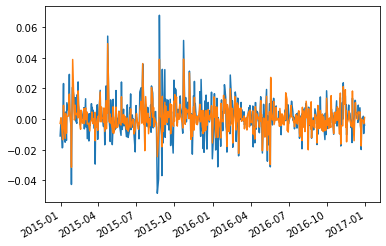

In [72]:
abnormal_return=fund_return-df_factor.drop(columns=['RF'])@model.params[1:]

fund_return.plot()
abnormal_return.plot()


- How can you produce the abnormal returns more easily simply using outputs from the regression you just run?

- Tip: what regression statistic is equal to the average of the abormal return

Bottom UP

- Now we estimate the factor loadings for each stock
- use our beautiful linear algebra to compute fund exposures



In [59]:
# estimating Factor Betas
df_factor, df_stocks = df_factor.align(df_stocks, join='inner', axis=0)

Xf = df_factor.drop(columns=['RF'])

B=pd.DataFrame([],index=tickers,columns=Xf.columns)
for ticker in df_stocks.columns:
    y = df_stocks[ticker]
    X = sm.add_constant(Xf) 
    X=X[y.isna()==False]
    y=y[y.isna()==False]
    model = sm.OLS(y, X).fit(dropna=True)
    B.loc[ticker,:]=model.params[1:]

B

,Mkt-RF,SMB,HML,RMW,CMA,MOM
AAPL,1.030717,-0.107237,-0.008217,0.763479,-1.460115,-0.030158
GOOGL,0.958094,-0.470574,-0.210335,-0.1177,-1.148522,0.144696
MSFT,1.231883,-0.314873,0.077865,0.656917,-1.120852,0.093478
NVDA,1.2523,0.698145,-0.239075,0.321978,-0.472794,0.165622
AMZN,0.995541,-0.438021,0.05142,-0.267262,-2.001092,0.238466
COST,0.791177,-0.035685,0.006976,0.723471,0.02207,0.207055
WMT,0.77975,-0.139923,-0.256882,0.862723,0.496919,0.106942
TGT,0.863384,0.297708,-0.108899,1.244263,0.541671,0.099742
KR,0.740051,0.048948,-0.026441,0.274185,-0.074022,0.309473


Once we have the Asset betas, then we can compute the fund betas date by date by using the current composition of the portfolio

Obviously this allows you to track the exposure of the fund much better

matters a lot for funds that trade at very high frequency

,Mkt-RF,SMB,HML,RMW,CMA,MOM
date,,,,,,
2014-12-31,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-01,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-02,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-05,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
2015-01-06,1.093707,-0.126512,-0.065668,0.271483,-1.240675,0.122421
...,...,...,...,...,...,...
2016-12-26,0.793590,0.042762,-0.096312,0.776160,0.246659,0.180803
2016-12-27,0.793590,0.042762,-0.096312,0.776160,0.246659,0.180803
2016-12-28,0.793590,0.042762,-0.096312,0.776160,0.246659,0.180803


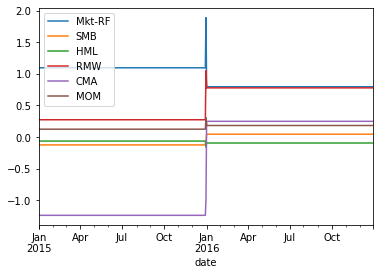

In [65]:
_temp=final_portfolio_df.merge(B,left_on='ticker',right_index=True,how='left') 
Fund_B = _temp.groupby('date').apply(lambda x: pd.Series((x[Xf.columns].values * x['weight'].values.reshape(-1, 1)).sum(axis=0), index=Xf.columns))
Fund_B.plot()
display(Fund_B)

How do we estimate the fund abnormal return with this approach?

Note that there is no reason to believe that the asset betas as stable. 

As we discussed, there is a lot of thought in deciding which sample is best to estimate the betas

- Long samples allow for more precision if the true beta is constant
- Shorter samples allow for you to capture time-variation


The general recipe that people use is 1-2 years when using daily data. 5 years when using monthly

## The Cross-Sectional Approach ( or Characteristic-based model)

In the time-series approach, we start from the factors and estimate the betas

Now we will flip this: we will start from the betas--which are the characteristic--and use a regression to tell us what is the return associated with this characteristic

That is, we will estimate the factors themselves!

The time-series approach requires 

- factors that are traded 
- Need to estimate the time-series beta as a first step for abnormal return construction

The Cross-sectional approach goes directly from characteristics to abnormal returns and is often the preferred choice across quant shops because it allows for very large set of factors

The goal is to estimate the returns associated with a characteristic in a particular date, but do that in a way that does not involve the complicated steps of portfolio formation that are hard to do for many characteristics at the same time

Recipe

1.  Get a large set of excess return for stocks (hopefully all) for a given date, R
2.  Get the characteristics of these same stocks , X for this "date". 
  - **Important**: the characteristics should be as of the the date before to avoid a spurious regression
  - it is useful to normalize the characteristics so we can in terms of standard deviations from the  average

3. Run the regression

$$R=BX+\epsilon$$

Note than from the OLS formula--If you have not seen this formula at some point in your life- today is the date!

$$B=(X'X)^{-1}X'R$$


- The B coefficients are excess returns themselves as they are just linear combinations of excess returns, i.e. the betas are portfolio returns
- They are returns on "pure play" portfolios. Portfolios designed to  take a loading of 1 on a charateristic and zero in all the others
- $(X'X)^{-1}X'$ are the weights on the pure play portfolio





In [ ]:
url = "https://github.com/amoreira2/Fin418/blob/main/assets/data/characteristics_raw.pkl?raw=true"

df_X = pd.read_pickle(url)
# This simply shits the date to be in an end of month basis


df_X.set_index(['date','permno'],inplace=True)
df_X


df_X

NameError: name 'pd' is not defined

In [108]:
# lets standardize the data
X_std=(df_X.drop(columns=['re','rf','rme']).groupby('date').transform(lambda x: (x-x.mean())/x.std()))

In [ ]:
#Lets start by picking a month
date='2006-09'
X=X_std.loc[date]
R=df_X.loc[date,'re']



# Run the regression
# multiplyin by 100 to get percentage
model = sm.OLS(100*R, X).fit()

# Print the summary of the regression
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                     re   R-squared (uncentered):                   0.158
Model:                            OLS   Adj. R-squared (uncentered):              0.131
Method:                 Least Squares   F-statistic:                              6.017
Date:                Fri, 17 Jan 2025   Prob (F-statistic):                    1.81e-20
Time:                        10:42:57   Log-Likelihood:                          1301.8
No. Observations:                 962   AIC:                                     -2546.
Df Residuals:                     933   BIC:                                     -2404.
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**What this means?**

- For example this means that a portfolio that takes one "unit" of the  the size anomaly and zero of everything else had a return in that month of 0.39%

- Value got clobbered with a return of -2.76%

- Because we normalize, it means you have a portfolio that has stocks with 1 standard deviation of the characteristic above the characteristic average in that date


What are the portfolios?

In [ ]:
#across lines we have the differnt characteristics and across columns we have the different stocks and their wights to implement the portfolio that is exposed to that chracteristic and nothign else

Characteristic_portfolio_weights=np.linalg.inv(X.T@X)@X.T
Characteristic_portfolio_weights

date   2006-09-30                                                              \
permno      10104     10107     10137     10138     10143     10145     10147   
0        0.002726  0.004360 -0.000686 -0.000294 -0.001032  0.001538  0.001587   
1       -0.002632  0.006965  0.000676  0.000402  0.001094  0.000918  0.000914   
2       -0.004929 -0.005258  0.002034  0.002285 -0.008617  0.002159 -0.000689   
3       -0.000836  0.000893 -0.000555 -0.000177  0.002782  0.001506  0.002053   
4       -0.001236  0.001006 -0.000597  0.000775 -0.000740  0.002011 -0.001833   
5        0.000264 -0.001071  0.001303  0.000584  0.002529  0.000491  0.000340   
6       -0.001617  0.000601 -0.000104 -0.000428 -0.002482 -0.000482 -0.000480   
7        0.002627 -0.002042 -0.001180  0.000641  0.006734  0.001257  0.000534   
8        0.004871  0.004464 -0.003664 -0.007132  0.007850 -0.000981  0.000484   
9        0.003855  0.004819 -0.002342 -0.003515  0.005676 -0.002311  0.000605   
10       0.000271 -0.000069 -0.000293  0.000143 -0.000826 -0.000250 -0.000066   
11      -0.000287  0.000121  0.000095 -0.000050  0.001933  0.000055  0.000081   
12      -0.001423 -0.001301 -0.001663 -0.005339 -0.005967  0.000626 -0.000846   
13       0.001069  0.001812 -0.000686  0.002124 -0.008606 -0.001630 -0.000170   
14      -0.000707 -0.000298  0.000059 -0.000892  0.002531  0.000550  0.000388   
15       0.000065  0.000296 -0.000223  0.002129 -0.000102 -0.000631 -0.000166   
16       0.003275 -0.001444  0.000414  0.000814  0.004850  0.000500 -0.000680   
17      -0.001036 -0.000790  0.001130 -0.000069 -0.000559  0.000744  0.001156   
18      -0.000448 -0.000538  0.000771  0.000531 -0.003858 -0.001458 -0.000226   
19      -0.000637 -0.000340  0.002424 -0.000383 -0.004906 -0.000384 -0.000023   
20       0.002454 -0.006450 -0.000259  0.000282 -0.000720 -0.001481  0.000044   
21       0.001268 -0.001002  0.000261  0.000340  0.002121  0.000014 -0.000332   
22       0.001438  0.000856  0.001983 -0.003842 -0.001651 -0.005159  0.008296   
23      -0.000693 -0.000813 -0.000575 -0.000243 -0.000003 -0.000482  0.000029   
24       0.001033 -0.001787 -0.000101  0.002654  0.001072  0.002249  0.000876   
25      -0.000593 -0.000945 -0.001676  0.004517  0.003180  0.004748 -0.007188   
26      -0.002615 -0.001900 -0.000078  0.000075  0.001128 -0.000128 -0.001855   
27       0.000211 -0.000759  0.001319  0.000274  0.002850  0.000730 -0.000111   
28      -0.000060  0.001666  0.000600 -0.002817  0.002260 -0.001090  0.000591   

date                                  ...                                \
permno     10182     10225     10299  ...     89702     89753     89757   
0      -0.000573  0.000838 -0.000320  ... -0.000651 -0.000082  0.002007   
1       0.001651  0.000402  0.000781  ...  0.002959 -0.001872 -0.017175   
2      -0.001997  0.003331 -0.006068  ... -0.019083  0.002454  0.003818   
3      -0.000181 -0.001518  0.001342  ...  0.000608 -0.000435 -0.001723   
4       0.001377 -0.000026 -0.000127  ...  0.000919  0.000659  0.001524   
5      -0.001383 -0.001643 -0.000055  ... -0.000987 -0.001089 -0.002098   
6       0.000256 -0.001693  0.000070  ...  0.001202  0.000048 -0.002312   
7       0.000382  0.002447 -0.000216  ... -0.000920 -0.000798  0.000595   
8      -0.008215 -0.003439  0.002336  ...  0.023270 -0.004813 -0.000239   
9       0.001060 -0.001483  0.003727  ...  0.011010 -0.002337 -0.002309   
10      0.006725  0.000147  0.000138  ... -0.000719  0.000504  0.000279   
11     -0.000231 -0.000377  0.000371  ... -0.000251 -0.000266 -0.000869   
12     -0.012928 -0.000303 -0.003485  ...  0.002164 -0.002672  0.003537   
13     -0.002489 -0.001095  0.002394  ...  0.000023  0.000402  0.000735   
14      0.000520  0.000250 -0.000938  ...  0.000191 -0.000201 -0.001692   
15      0.017161 -0.000159  0.001461  ... -0.002150  0.000303 -0.001075   
16     -0.001967  0.001638  0.001538  ... -0.000963  0.006294  0.006965   
17     -0.000728 -0.003179 -0.000662  ... -0.000162  0.000246  

What do we do with this?

1. For a give portfolio I can exactly compute it's charaterestic-adjusted portfolio returns
2. I can also construct a time-series of return for each characteristic, by simply splicing together the regression coefficients of different dates.
  - Essentially I would run a for loop and get a sequence of betas $[\beta_t,\beta_{t+1},...]$ and these would be the returns on the factors




### Constructing Characteristic adjusted returns


We can get the portfolio characteristics and based on that construct the return implied by these characteristics

We then subtract these characteristic returns from the portfolio returns

It is the equivalent of the "hedged portfolios" that uses the betas to hedge. Here we simply use the characterisitc--instead of makign "factor" neutral we make them characteristic neutral

Are these the same thing?

In [ ]:
# Step 1: construct 2 portfolios 1 and 2 ( tech and retail)

portfolio_data1 = {'port': [1,1,1,1,1],
    'ticker': ['AAPL', 'GOOG', 'MSFT','NVDA','AMZN'],
    'weight': [0.2,0.2, 0.2,0.2,0.2]
}

portfolio_data2 = {'port': [2,2,2,2],
    'ticker': ['COST', 'WMT', 'TGT','KR'],
    'weight': [0.25,0.25, 0.25,0.25]
}

portfolio_df1 = pd.DataFrame(portfolio_data1)
portfolio_df2 = pd.DataFrame(portfolio_data2)
portfolio_df = pd.concat([portfolio_df1, portfolio_df2], ignore_index=True)
print(portfolio_df)




C:\Users\Alan.Moreira\AppData\Local\Temp\ipykernel_42500\2476330753.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portfolio_df=portfolio_df1.append(portfolio_df2)


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,ticker,namedt,nameenddt
276,10107,MSFT,1986-03-13,2023-12-29
9575,14542,GOOG,2014-04-03,2015-10-04
9576,14542,GOOG,2015-10-05,2023-12-29
9663,14593,AAPL,1980-12-12,2007-01-10
9664,14593,AAPL,2007-01-11,2023-12-29
13089,16678,KR,1962-07-02,1968-01-01
13090,16678,KR,1968-01-02,2023-12-29
25347,25225,COST,1972-12-14,1979-07-10
26009,26542,TGT,1962-07-02,1966-04-12
26010,26542,TGT,1966-04-13,1968-01-01


In [ ]:
# Step 2: Get the permnos associated with these ticker so we can do the matching
# our data has permnos, not tickers
conn=wrds.Connection()
# get the pemnos for the tickers
permno=get_permnos(portfolio_df.ticker.unique(),conn)

permno['namedt'] = pd.to_datetime(permno['namedt'])
permno['nameenddt'] = pd.to_datetime(permno['nameenddt'])

date='2008-03'
d = pd.to_datetime(date)
# note that sometimes the pernmo changes!
# so we need to get the permnos that are valid at the relevant date
permno_d=permno[(permno['nameenddt']>=d) & (permno['namedt']<=d)]

portfolio_df=portfolio_df.merge(permno_d[['permno','ticker']],on='ticker',how='left') 
portfolio_df

In [ ]:
# Step 3: merge our portfolio with our main data set that contains returns and characterisitc
# here we are doign just for one date. Of course you can also do for multiple dates. 
#IF the portfolios are fixed that is trivial. If the portfolio is changing , then you should have two identifiers for your
#portfolio in step 1 "port" and "date"


X=X_std.loc[date].reset_index()
port_stocks_X=portfolio_df.merge(X,left_on='permno',right_on='permno',how='left')
port_stocks_X



c:\Users\Alan.Moreira\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,port,ticker,weight,permno,date,size,value,prof,fscore,debtiss,...,momrev,valuem,nissm,strev,ivol,betaarb,indrrev,price,age,shvol
0,1,AAPL,0.20,14593,2008-03-31,2.410205,-1.315480,0.455224,-0.091077,1.303219,...,0.575718,-1.421058,0.147848,-0.580727,0.330686,0.752957,-0.868990,1.888114,0.398208,2.904418
1,1,GOOG,0.20,90319,2008-03-31,2.528013,-1.118659,0.564933,-0.091077,1.303219,...,0.755154,-1.005315,0.229125,-1.402481,0.158169,-0.694430,-1.224557,3.959159,-2.339689,1.693268
2,1,MSFT,0.20,10107,2008-03-31,3.257090,-1.363239,0.985259,0.755457,1.303219,...,0.726842,-1.531135,-0.438239,-1.377024,-0.637930,-0.456596,-1.195484,-0.492776,0.105671,-0.399737
3,1,NVDA,0.20,86580,2008-03-31,0.680226,-1.634531,0.817117,0.755457,1.303219,...,1.172971,-0.842731,0.223491,-1.079041,1.603828,2.812533,-1.183732,-0.867861,-1.084778,1.545659
4,1,AMZN,0.20,84788,2008-03-31,1.240524,-3.728875,1.118980,-0.091077,1.303219,...,1.249185,-3.528315,0.034269,-1.451173,0.544068,1.264655,-1.341326,0.854323,-0.858657,1.347997
5,2,COST,0.25,87055,2008-03-31,1.154301,0.138992,0.785716,-0.091077,-0.766462,...,-0.499439,-0.268807,-0.301382,-0.674229,-0.579135,-0.414050,-0.454017,0.791327,0.126212,0.223698
6,2,WMT,0.25,55976,2008-03-31,2.960595,-0.322603,1.029022,-0.937610,-0.766462,...,-0.424544,-0.260600,-0.348921,-0.082608,-1.065065,-0.802397,0.221643,0.444707,0.753804,-1.140483
7,2,TGT,0.25,49154,2008-03-31,1.815796,-0.209013,0.909948,1.601991,-0.766462,...,0.974779,-0.055104,-0.423087,-0.319158,0.450388,0.077535,-0.048508,0.536987,0.871398,0.443988
8,2,KR,0.25,16678,2008-03-31,0.934108,-0.149013,1.326149,0.755457,-0.766462,...,-0.172023,-0.295956,-0.406029,-0.282320,-0.487468,-0.728124,-0.006437,-0.671970,1.220560,-0.344465


Now we can compute each portfolio characteristic

In [ ]:
# step 4: finally we simply average the characteristics within each portfolio
# we now know how value, momentum, and so on is our portfolio as a funciton of what they hold

X_names=X.drop(columns=['permno','date']).columns
port_X=port_stocks_X.groupby('port').apply(lambda x: x['weight'] @ x[X_names])
port_X

We can then compute the portfolio "characteristic-implied" returns and the portfolio characteristic-adjusted return

In [ ]:
# Step 5:  estimate the return associated with each characteristic  using the entire investment universe
# we already this step above, but I am repeating here for completeness
# you eould have to repeat this procedure date by data if doign that for multiple dates

X=X_std.loc[date]
R=df_X.loc[date,'re']

# Run the regression
model = sm.OLS(R, X).fit()

R_X=model.params
R_X

port
1   -0.027497
2    0.006339
dtype: float64
port
1    0.029733
2    0.030074
dtype: float64
port
1    0.057230
2    0.023735
dtype: float64


In [ ]:

# Step6: compute the charateteristic implied returns by using the portfolio chanrateristics to compute the portfolio returns
#implied by these characteristics. This the equivalent of $\sum \beta f_{t}^i$, but here port_X are the "betas" 
# and R_X and the factors--the returns associated with the charateristic 

port_characteristic_returns=port_X[X_names] @R_X
print(port_characteristic_returns)

In [ ]:
# step 7: Subtract the charateristic implied return from the portfolio return to obtain the charateristic-adjsuted retrun
# this is the equivalent of $R^{port}_t-\sum \beta f_{t}^i$

# portfolio  raw excess return
_temp=portfolio_df.merge(R.reset_index(),left_on='permno',right_on='permno')
R_port=_temp.groupby('port').apply(lambda x: x['weight']@ x['re'])
print(R_port)

#  characteristic-adjsuted
Port_characteristic_adjsuted_returns=R_port-port_characteristic_returns
print(Port_characteristic_adjsuted_returns)

Why practitioners like this?

- You don't need the time-series betas and all the issues with the size of the sample and how they might move around
- All you need is the characteristic at a given date, and that characteristic can move around a lot as we estimate date by date
- We used no time-series data at all
- You can have very large number of factors: can add sector/industry factors, country factors, currency factors, you name it. Just add to your regression

What are the issues?

- The main issue is that ignores covariances, so the characteristic-adjusted portfolios are characteristic neutral but not factor neutral 
   - For example: a stock might be large but co-move with small stocks and not large stocks, a stock might be classified as retail but co-move with tech
   - of course we only care about the characteristics because they describe movement in returns
   - But this might or might not be true and we re almost certain that it will be suboptimal
   - Now as the number of characteristics grow and they describe returns better and better, this becomes less of an issue
   - Consistent with the industry practice of have large set of characteristics (often north of 50-100)

- Another issue is that this approach will tend to load on small stocks
    - Basically the OLS tries to fit all data points equally and most stocks are tiny
    - One fix is to use Weighted-Least Squares where you put more weight on larger firms
    - or simply estimate your characteristic returns eliminating the smallest stocks--say focus on the top 20% by market cap




---
**📝 Key Takeaways**

- **Enhanced Risk Modeling**: Multi-factor models provide a more nuanced view of asset returns by considering multiple sources of systematic risk, leading to better risk assessment and management.

- **Improved Covariance Estimation**: By decomposing returns into factor and idiosyncratic components, these models yield more stable and reliable covariance matrices, essential for portfolio optimization. 

- **Dynamic Portfolio Analysis**: Understanding how individual assets contribute to overall portfolio risk enables more informed decisions regarding asset inclusion or exclusion.

- **Performance Attribution**: Decomposing portfolio returns into factor contributions helps in evaluating investment strategies and manager performance.

- **From Micro to Macro**: Aggregating individual asset exposures provides insights into the broader portfolio's sensitivity to various risk factors.

- **Cross-Sectional Insights**: Characteristic-based models offer an alternative perspective by linking firm-specific attributes to expected returns, enriching the analytical toolkit of the portfolio manager

---